In [1]:
import torch
import torch.autograd as autograd
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

In [2]:
!pip install pyro-ppl

In [4]:
import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample
import torch.nn as nn

from pyro.infer import MCMC, NUTS, Predictive


pyro.set_rng_seed(42)

In [5]:
# Real Observations

t_obs = torch.linspace(0., 8., 1600).unsqueeze(-1)          # 1600 × 1
u_true = 0.5*t_obs**2 + t_obs
noise = 0.1
u_obs = u_true + noise * torch.randn_like(u_true)     # 1600 X 1
# u_obs = u_obs.squeeze()       # 1600,


# Collocation Points
t_pde = torch.linspace(0., 8., 1000).unsqueeze(-1).requires_grad_(True)

# initial condition point
t_ic = torch.tensor([[0.0]])

In [6]:
class PhyBNN(PyroModule):
    def __init__(self, in_dim=1, out_dim=1, hid_dim=20):
        super().__init__()

        self.activation = nn.Tanh()  
        self.layer1 = PyroModule[nn.Linear](in_dim, hid_dim)  # Input to hidden layer
        self.layer2 = PyroModule[nn.Linear](hid_dim, hid_dim)
        self.layer3 = PyroModule[nn.Linear](hid_dim, out_dim)  # Hidden to output layer

        # Set layer parameters as random variables
        self.layer1.weight = PyroSample(dist.Normal(0., 1.).expand([hid_dim, in_dim]).to_event(2))
        self.layer1.bias = PyroSample(dist.Normal(0., 10.).expand([hid_dim]).to_event(1))
        self.layer2.weight = PyroSample(dist.Normal(0., 1.).expand([hid_dim, hid_dim]).to_event(2))
        self.layer2.bias = PyroSample(dist.Normal(0., 10.).expand([hid_dim]).to_event(1))
        self.layer3.weight = PyroSample(dist.Normal(0., 1.).expand([out_dim, hid_dim]).to_event(2))
        self.layer3.bias = PyroSample(dist.Normal(0., 10.).expand([out_dim]).to_event(1))

    def forward(self,t):
        h_1 = self.activation(self.layer1(t))
        h_2 = self.activation(self.layer2(h_1))
        return self.layer3(h_2).squeeze(-1)
    


In [7]:
def model_pinn(t_pde, t_ic):
    
    net = PhyBNN()

    # t_pde = t_pde.detach().requires_grad_(True)
    t_pde = t_pde.requires_grad_()
    t_ic  = t_ic.requires_grad_()

    t_all = torch.cat([t_pde, t_ic], dim=0).requires_grad_()
    
    # u_all = net(t_all)
    # u_pde, u_ic = u_all[: len(t_pde)], u_all[len(t_pde) :]

    # print(u_pde)
    
    n_pde = t_pde.shape[0]
    
    #PDE
    # u_pred_pde = net(t_pde)

    with torch.enable_grad():
        u_all = net(t_all)
        u_pde, u_ic = u_all[: len(t_pde)], u_all[len(t_pde) :]
        du_dt_all = torch.autograd.grad(u_all,t_all,grad_outputs=torch.ones_like(u_all), create_graph=True)[0]
        
    # du_dt_all = torch.autograd.grad(u_all,t_all,grad_outputs=torch.ones_like(u_all), create_graph=True)[0]
    du_dt = du_dt_all[:n_pde]
    res_pde = du_dt - t_all[:n_pde]
    #IC
    # u_pred_ic = net(t_ic)
    res_ic = u_ic

    # Likelihoods
    with pyro.plate('pde_plate',len(t_pde)):
        pyro.sample('pde_obs', dist.Normal(0.,1e-1), obs = res_pde.squeeze())
    with pyro.plate('ic_plate',len(t_ic)):
        pyro.sample('ic_obs', dist.Normal(0.,1e-1), obs = res_ic.squeeze())


    



In [8]:
from pyro.infer import SVI, Trace_ELBO, Predictive
from pyro.optim import Adam
from pyro.infer.autoguide import AutoDiagonalNormal
from pyro.infer.autoguide import AutoLowRankMultivariateNormal

In [ ]:
# pyro.clear_param_store()
# nuts_kernel = NUTS(model_pinn, adapt_step_size=True)
# mcmc = MCMC(nuts_kernel, num_samples=400, warmup_steps=100, num_chains=1)
# mcmc.run(t_pde,t_ic)





Sample: 100%|██████████| 500/500 [16:24,  1.97s/it, step size=8.81e-04, acc. prob=0.674]


In [ ]:
# posterior_samples = mcmc.get_samples()

# for name, vals in posterior_samples.items():
#     print(name, vals.shape)

layer1.bias torch.Size([400, 20])
layer1.weight torch.Size([400, 20, 1])
layer2.bias torch.Size([400, 20])
layer2.weight torch.Size([400, 20, 20])
layer3.bias torch.Size([400, 1])
layer3.weight torch.Size([400, 1, 20])


In [9]:
pyro.clear_param_store()
# guide = AutoDiagonalNormal(model_pinn)          # uses your existing model_pinn
guide = AutoLowRankMultivariateNormal(model_pinn, rank = 20)
optimizer = Adam({"lr": 1e-3})
svi = SVI(model_pinn, guide, optimizer, loss=Trace_ELBO())

In [10]:
num_steps = 10000
for step in range(num_steps):
    loss = svi.step(t_pde, t_ic)                # matches your model signature
    if (step + 1) % 500 == 0:
        print(f"[SVI] step {step+1:5d}  ELBO: {loss:.4f}")

[SVI] step   500  ELBO: 300893.6750
[SVI] step  1000  ELBO: 17529.2231
[SVI] step  1500  ELBO: 16977.9872
[SVI] step  2000  ELBO: 66900.4830
[SVI] step  2500  ELBO: 5984.5849
[SVI] step  3000  ELBO: 11366.6236
[SVI] step  3500  ELBO: 35065.4672
[SVI] step  4000  ELBO: 8723.0212
[SVI] step  4500  ELBO: 7379.9322
[SVI] step  5000  ELBO: 5127.5255
[SVI] step  5500  ELBO: 1063.8411
[SVI] step  6000  ELBO: 16854.7467
[SVI] step  6500  ELBO: 1598.7276
[SVI] step  7000  ELBO: 4312.8820
[SVI] step  7500  ELBO: 9019.7767
[SVI] step  8000  ELBO: 9088.2336
[SVI] step  8500  ELBO: 1377.5898
[SVI] step  9000  ELBO: 3650.7194
[SVI] step  9500  ELBO: 1693.4707
[SVI] step 10000  ELBO: 5936.5033


In [11]:
def predict_model(t_test):
    net = PhyBNN()                              # same PyroModule with PyroSample sites
    return net(t_test).squeeze(-1)  

In [12]:
K = 1000                                         # number of posterior weight samples
t_test = torch.linspace(0., 8., 600).unsqueeze(-1)

In [13]:
latent_names = [n for n, _ in PhyBNN().named_parameters()]

predictive = Predictive(model_pinn, guide=guide, num_samples=K, return_sites=latent_names)
vi_samples = predictive(t_pde, t_ic)   # match your model_pinn signature

# print shapes (K, *param_shape)
for name, vals in vi_samples.items():
    print(name, tuple(vals.shape))

layer1.weight (1000, 1, 20, 1)
layer1.bias (1000, 1, 20)
layer2.weight (1000, 1, 20, 20)
layer2.bias (1000, 1, 20)
layer3.weight (1000, 1, 1, 20)
layer3.bias (1000, 1, 1)
pde_obs (1000, 1000)
ic_obs (1000,)


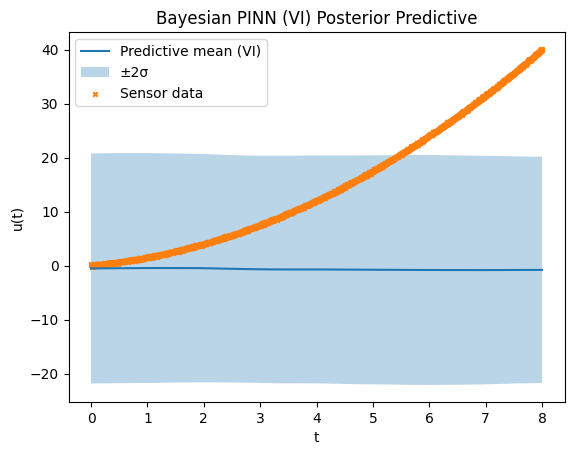

In [14]:
t_test = torch.linspace(0., 8., 600).unsqueeze(-1)

K = vi_samples["layer1.weight"].shape[0]   # number of VI draws
K_use = min(K, 200)                        # use up to 200 for plotting

all_u = []
for i in range(K_use):
    net_i = PhyBNN()                       # fresh net
    # load i-th draw into this net
    sd = net_i.state_dict()
    for name, vals in vi_samples.items():
        if name in sd:                     # only layer params, skip obs sites
            sd[name] = vals[i]
    net_i.load_state_dict(sd, strict=False)

    with torch.no_grad():
        all_u.append(net_i(t_test).squeeze(-1))

all_u = torch.stack(all_u)                 # [K_use, N_test]
u_mean = all_u.mean(0)
u_std  = all_u.std(0)

# --- Plot ---
plt.figure()
plt.plot(t_test.numpy(), u_mean.numpy(), label="Predictive mean (VI)")
plt.fill_between(
    t_test.numpy().ravel(),
    (u_mean - 2*u_std).numpy(),
    (u_mean + 2*u_std).numpy(),
    alpha=0.3, label="±2σ"
)
plt.scatter(t_obs.numpy(), u_obs.numpy(), s=10, marker='x', label='Sensor data')
plt.xlabel("t"); plt.ylabel("u(t)")
plt.title("Bayesian PINN (VI) Posterior Predictive")
plt.legend()
plt.show()

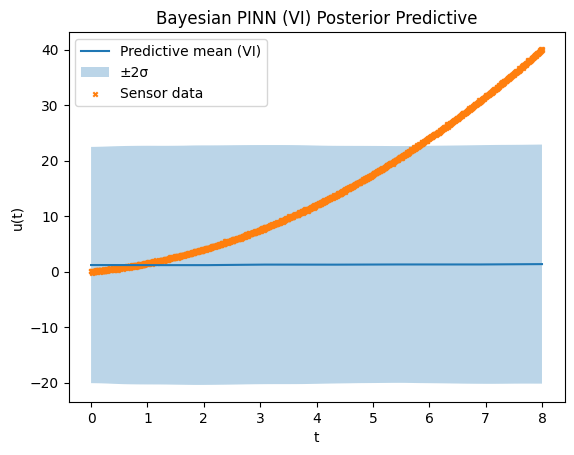

In [15]:
t_test = torch.linspace(0., 8., 600).unsqueeze(-1)

K = vi_samples["layer1.weight"].shape[0]   # number of VI draws
K_use = min(K, 200)                        # use up to 200 for plotting

all_u = []

for i in range(K_use):
    net_i = PhyBNN()
    net_i.eval()
    sd = net_i.state_dict()
    for name, vals in vi_samples.items():
        if name in sd:
            sd[name] = vals[i].squeeze(0).to(sd[name].dtype).to(sd[name].device)
    missing, unexpected = net_i.load_state_dict(sd, strict=False)
    # Optional sanity check:
    # assert not missing and not unexpected, (missing, unexpected)

    with torch.no_grad():
        all_u.append(net_i(t_test).squeeze(-1))


all_u = torch.stack(all_u)                 # [K_use, N_test]
u_mean = all_u.mean(0)
u_std  = all_u.std(0)

# --- Plot ---
plt.figure()
plt.plot(t_test.numpy(), u_mean.numpy(), label="Predictive mean (VI)")
plt.fill_between(
    t_test.numpy().ravel(),
    (u_mean - 2*u_std).numpy(),
    (u_mean + 2*u_std).numpy(),
    alpha=0.3, label="±2σ"
)
plt.scatter(t_obs.numpy(), u_obs.numpy(), s=10, marker='x', label='Sensor data')
plt.xlabel("t"); plt.ylabel("u(t)")
plt.title("Bayesian PINN (VI) Posterior Predictive")
plt.legend()
plt.show()

In [ ]:
# def model_pinn_return(t_pde,t_ic):
#     net = PhyBNN()
#     return net(t_pde)

In [ ]:
# t_test = torch.linspace(0., 8., steps=1000).unsqueeze(-1)


# predictive = Predictive(model_pinn_return,posterior_samples=posterior_samples,return_sites=["_RETURN"])

# output = predictive(t_test, t_ic)
# print(output.keys())

# u_pred_samples = output["_RETURN"]   # shape [S, N]
# print(u_pred_samples.shape)

# u_pred_samples = output["_RETURN"]    # shape [num_samples, len(t_test)]

# mean_pred = u_pred_samples.mean(0)
# std_pred = u_pred_samples.std(dim=0)
# lower_90  = u_pred_samples.quantile(0.10, dim=0)
# upper_90  = u_pred_samples.quantile(0.90, dim=0)

# print((upper_90 - lower_90).mean().item())

dict_keys(['_RETURN'])
torch.Size([400, 1000])
0.27535831928253174


In [26]:
# x = t_test.squeeze().numpy()
# plt.plot(x, mean_pred, label="Posterior mean")
# plt.fill_between(x, lower_90, upper_90, alpha=0.3, label="90% CI")
# # plt.fill_between(x, mean_pred - 2*std_pred, mean_pred + 2*std_pred, alpha=0.3, label="±2 std")
# plt.scatter(t_obs.numpy(), u_obs.numpy(), c="k", s=10, label="Noisy data")
# plt.legend()
# plt.xlabel("t"); plt.ylabel("u(t)")
# plt.show()

In [ ]:
# Stage 2: Condition on data, starting from the physics‐informed posterior


# mean_w1 = posterior_samples["layer1.weight"].mean(0)
# std_w1  = posterior_samples["layer1.weight"].std(0)

# print(mean_w1.shape)

# mean_b1 = posterior_samples["layer1.bias"].mean(0)
# std_b1 = posterior_samples["layer1.bias"].std(0)

# print(mean_b1.shape)





# mean_w2 = posterior_samples["layer2.weight"].mean(0)
# std_w2  = posterior_samples["layer2.weight"].std(0)

# mean_b2 = posterior_samples["layer2.bias"].mean(0)
# std_b2 = posterior_samples["layer2.bias"].std(0)


# print(mean_w2.shape)
# print(mean_b2.shape)



# mean_w3 = posterior_samples["layer3.weight"].mean(0)
# std_w3  = posterior_samples["layer3.weight"].std(0)

# mean_b3 = posterior_samples["layer3.bias"].mean(0)
# std_b3 = posterior_samples["layer3.bias"].std(0)

# print(mean_w3.shape)
# print(mean_b3.shape)


torch.Size([20, 1])
torch.Size([20])
torch.Size([20, 20])
torch.Size([20])
torch.Size([1, 20])
torch.Size([1])


In [16]:
def vi_mean_std(name):
    vals = vi_samples[name]            # shape: (K, 1, *param_shape)
    mean = vals.mean(0).squeeze(0)     # -> (*param_shape)
    std  = vals.std(0).squeeze(0)      # -> (*param_shape)
    return mean, std

# ----- Layer 1 -----
mean_w1, std_w1 = vi_mean_std("layer1.weight")
mean_b1, std_b1 = vi_mean_std("layer1.bias")
print("layer1.weight:", tuple(mean_w1.shape))
print("layer1.bias  :", tuple(mean_b1.shape))

# ----- Layer 2 -----
mean_w2, std_w2 = vi_mean_std("layer2.weight")
mean_b2, std_b2 = vi_mean_std("layer2.bias")
print("layer2.weight:", tuple(mean_w2.shape))
print("layer2.bias  :", tuple(mean_b2.shape))

# ----- Layer 3 -----
mean_w3, std_w3 = vi_mean_std("layer3.weight")
mean_b3, std_b3 = vi_mean_std("layer3.bias")
print("layer3.weight:", tuple(mean_w3.shape))
print("layer3.bias  :", tuple(mean_b3.shape))

layer1.weight: (20, 1)
layer1.bias  : (20,)
layer2.weight: (20, 20)
layer2.bias  : (20,)
layer3.weight: (1, 20)
layer3.bias  : (1,)


In [ ]:
# class PhyDataBNN(PyroModule):
#     def __init__(self, in_dim=1, out_dim=1, hid_dim=20):
#         super().__init__()

#         self.activation = nn.Tanh()  
#         self.layer1 = PyroModule[nn.Linear](in_dim, hid_dim)  # Input to hidden layer
#         self.layer2 = PyroModule[nn.Linear](hid_dim, hid_dim)
#         self.layer3 = PyroModule[nn.Linear](hid_dim, out_dim)  # Hidden to output layer

#         # Set layer parameters as random variables
#         self.layer1.weight = PyroSample(dist.Normal(mean_w1, std_w1).expand([hid_dim, in_dim]).to_event(2))
#         self.layer1.bias = PyroSample(dist.Normal(mean_b1, std_b1).expand([hid_dim]).to_event(1))
#         self.layer2.weight = PyroSample(dist.Normal(mean_w2, std_w2).expand([hid_dim, hid_dim]).to_event(2))
#         self.layer2.bias = PyroSample(dist.Normal(mean_b2, std_b2).expand([hid_dim]).to_event(1))
#         self.layer3.weight = PyroSample(dist.Normal(mean_w3, std_w3).expand([out_dim, hid_dim]).to_event(2))
#         self.layer3.bias = PyroSample(dist.Normal(mean_b3, std_b3).expand([out_dim]).to_event(1))

#     def forward(self,t):
#         h_1 = self.activation(self.layer1(t))
#         h_2 = self.activation(self.layer2(h_1))
#         return self.layer3(h_2).squeeze(-1)
    


In [17]:
class PhyDataBNN(PyroModule):
    def __init__(self, in_dim=1, out_dim=1, hid_dim=20):
        super().__init__()
        self.activation = nn.Tanh()
        self.layer1 = PyroModule[nn.Linear](in_dim, hid_dim)
        self.layer2 = PyroModule[nn.Linear](hid_dim, hid_dim)
        self.layer3 = PyroModule[nn.Linear](hid_dim, out_dim)

        eps = 1e-6  # to avoid zero std

        # weights/biases: use Stage-1 posteriors as priors for Stage-2
        self.layer1.weight = PyroSample(dist.Normal(mean_w1.detach(), (std_w1+eps).detach()).to_event(2))
        self.layer1.bias   = PyroSample(dist.Normal(mean_b1.detach(), (std_b1+eps).detach()).to_event(1))

        self.layer2.weight = PyroSample(dist.Normal(mean_w2.detach(), (std_w2+eps).detach()).to_event(2))
        self.layer2.bias   = PyroSample(dist.Normal(mean_b2.detach(), (std_b2+eps).detach()).to_event(1))

        self.layer3.weight = PyroSample(dist.Normal(mean_w3.detach(), (std_w3+eps).detach()).to_event(2))
        self.layer3.bias   = PyroSample(dist.Normal(mean_b3.detach(), (std_b3+eps).detach()).to_event(1))

    def forward(self, t):
        h1 = self.activation(self.layer1(t))
        h2 = self.activation(self.layer2(h1))
        return self.layer3(h2).squeeze(-1)

In [ ]:
# def model_pinn_data(t_pde, t_ic,t_obs):
    
#     net_2 = PhyDataBNN()

#     # t_pde = t_pde.detach().requires_grad_(True)
#     t_pde = t_pde.requires_grad_()
#     t_ic  = t_ic.requires_grad_()
#     t_obs = t_obs.requires_grad_()

#     t_all_2 = torch.cat([t_pde, t_ic,t_obs], dim=0).requires_grad_()
    
#     u_all_2 = net_2(t_all_2)
#     u_pde, u_ic,u_pred_data = u_all_2[: len(t_pde)], u_all_2[len(t_pde) : len(t_pde) + len(t_ic)], u_all_2[len(t_pde) + len(t_ic):]
#     n_pde = t_pde.shape[0]
    
#     #PDE
#     # u_pred_pde = net(t_pde)
#     du_dt_all = torch.autograd.grad(u_all_2,t_all_2,grad_outputs=torch.ones_like(u_all_2), create_graph=True)[0]
#     du_dt = du_dt_all[:n_pde]
#     res_pde = du_dt - t_all_2[:n_pde]
#     #IC
#     # u_pred_ic = net(t_ic)
#     res_ic = u_ic

#     # u_data_pred = net_2(t_obs)

#     # Likelihoods
#     with pyro.plate('pde_plate',len(t_pde)):
#         pyro.sample('pde_obs', dist.Normal(0.,1e-1), obs = res_pde.squeeze())
#     with pyro.plate('ic_plate',len(t_ic)):
#         pyro.sample('ic_obs', dist.Normal(0.,1e-1), obs = res_ic.squeeze())
#     with pyro.plate('data',len(t_obs)):
#         pyro.sample('obs', dist.Normal(u_pred_data,1e-1), obs = u_obs)
    



In [ ]:
# def model_pinn_data(t_pde, t_ic,t_obs,u_obs):
    
#     net_2 = PhyDataBNN()

#     # t_pde = t_pde.detach().requires_grad_(True)
#     t_pde = t_pde.requires_grad_()
#     t_ic  = t_ic.requires_grad_()
#     t_obs = t_obs.requires_grad_()

#     t_all_2 = torch.cat([t_pde, t_ic,t_obs], dim=0).requires_grad_()
    
#     u_all_2 = net_2(t_all_2)
#     u_pde, u_ic,u_pred_data = u_all_2[: len(t_pde)], u_all_2[len(t_pde) : len(t_pde) + len(t_ic)], u_all_2[len(t_pde) + len(t_ic):]
#     n_pde = t_pde.shape[0]
    
#     #PDE
#     # u_pred_pde = net(t_pde)
#     du_dt_all = torch.autograd.grad(u_all_2,t_all_2,grad_outputs=torch.ones_like(u_all_2), create_graph=True)[0]
#     du_dt = du_dt_all[:n_pde]
#     res_pde = du_dt - t_all_2[:n_pde]
#     #IC
#     # u_pred_ic = net(t_ic)
#     res_ic = u_ic

#     # u_data_pred = net_2(t_obs)

#     # Likelihoods
#     with pyro.plate('pde_plate',len(t_pde)):
#         pyro.sample('pde_obs', dist.Normal(0.,1e-1), obs = res_pde.squeeze())
#     with pyro.plate('ic_plate',len(t_ic)):
#         pyro.sample('ic_obs', dist.Normal(0.,1e-1), obs = res_ic.squeeze())
#     with pyro.plate('data',len(t_obs)):
#         pyro.sample('obs', dist.Normal(u_pred_data,1e-1), obs = u_obs)

In [22]:
def model_pinn_data(t_pde, t_ic, t_obs, u_obs):
    net_2 = PhyDataBNN()

    # grads only for PDE points
    t_pde = t_pde.detach().requires_grad_(True)
    t_ic  = t_ic.detach()
    t_obs = t_obs.detach()

    n_pde, n_ic = t_pde.shape[0], t_ic.shape[0]
    t_all = torch.cat([t_pde, t_ic, t_obs], dim=0)

    with torch.enable_grad():
        u_all = net_2(t_all).squeeze(-1)             # <- squeeze to 1-D

        u_pde       = u_all[:n_pde]                      # [n_pde]
        u_ic        = u_all[n_pde:n_pde+n_ic]            # [n_ic]
        u_pred_data = u_all[n_pde+n_ic:]                 # [n_obs]

  
        du_dt = torch.autograd.grad(u_pde, t_pde,
                                    grad_outputs=torch.ones_like(u_pde),
                                    create_graph=True)[0].squeeze(-1)
    res_pde = du_dt - t_pde.squeeze(-1)              # [n_pde]
    res_ic  = u_ic                                   # [n_ic]

    # (recommend learning sigmas; fixed here for minimal change)
    with pyro.plate('pde_plate', n_pde):
        pyro.sample('pde_obs', dist.Normal(0., 1e-1), obs=res_pde)

    with pyro.plate('ic_plate', n_ic):
        pyro.sample('ic_obs',  dist.Normal(0., 1e-1), obs=res_ic)

    with pyro.plate('data', t_obs.shape[0]):
        pyro.sample('obs', dist.Normal(u_pred_data, 1e-1),
                    obs=u_obs.squeeze(-1))  

In [24]:
print("t_pde", t_pde.shape, "requires_grad", t_pde.requires_grad)
print("t_ic ", t_ic.shape,  "requires_grad", t_ic.requires_grad)
print("t_obs", t_obs.shape, "requires_grad", t_obs.requires_grad)
print("u_obs", u_obs.shape)

t_pde torch.Size([1000, 1]) requires_grad True
t_ic  torch.Size([1, 1]) requires_grad True
t_obs torch.Size([1600, 1]) requires_grad False
u_obs torch.Size([1600, 1])


In [ ]:
# pyro.clear_param_store()
# nuts_kernel_2 = NUTS(model_pinn_data, adapt_step_size=True)
# mcmc_2 = MCMC(nuts_kernel_2, num_samples=400, warmup_steps=100, num_chains=1)
# mcmc_2.run(t_pde,t_ic,t_obs)

Sample: 100%|██████████| 500/500 [00:20, 24.47it/s, step size=1.53e-06, acc. prob=0.508]


In [ ]:
# posterior_samples_2 = mcmc_2.get_samples()

# for name, vals in posterior_samples_2.items():
#     print(name, vals.shape)

layer1.bias torch.Size([400, 20])
layer1.weight torch.Size([400, 20, 1])
layer2.bias torch.Size([400, 20])
layer2.weight torch.Size([400, 20, 20])
layer3.bias torch.Size([400, 1])
layer3.weight torch.Size([400, 1, 20])


In [25]:
pyro.clear_param_store()
# guide = AutoDiagonalNormal(model_pinn)          # uses your existing model_pinn
guide_2 = AutoLowRankMultivariateNormal(model_pinn_data, rank = 20)
optimizer_2 = Adam({"lr": 1e-3})
svi_2 = SVI(model_pinn_data, guide_2, optimizer_2, loss=Trace_ELBO())

In [27]:
num_steps = 10000
pyro.set_rng_seed(0)
for step in range(num_steps):
    loss = svi_2.step(t_pde, t_ic, t_obs, u_obs)                # matches your model signature
    if (step + 1) % 500 == 0:
        print(f"[SVI-2] step {step+1:5d}  ELBO: {loss:.4f}")

[SVI-2] step   500  ELBO: 65221.3499
[SVI-2] step  1000  ELBO: 60088.1442
[SVI-2] step  1500  ELBO: 55772.2410
[SVI-2] step  2000  ELBO: 81618.9574
[SVI-2] step  2500  ELBO: 57042.2601
[SVI-2] step  3000  ELBO: 71821.3394
[SVI-2] step  3500  ELBO: 52040.9030
[SVI-2] step  4000  ELBO: 115802.3555
[SVI-2] step  4500  ELBO: 52617.0134
[SVI-2] step  5000  ELBO: 80700.4862
[SVI-2] step  5500  ELBO: 46387.6579
[SVI-2] step  6000  ELBO: 46527.9521
[SVI-2] step  6500  ELBO: 47370.7342
[SVI-2] step  7000  ELBO: 59297.8700
[SVI-2] step  7500  ELBO: 57212.2208
[SVI-2] step  8000  ELBO: 55615.3390
[SVI-2] step  8500  ELBO: 46168.3939
[SVI-2] step  9000  ELBO: 47501.8020
[SVI-2] step  9500  ELBO: 51673.6092
[SVI-2] step 10000  ELBO: 42733.0410


In [28]:
def predict_model_data(t_test):
    net = PhyDataBNN()                 # uses Stage-1 posterior as priors
    return net(t_test).squeeze(-1)

In [31]:
K = 200
t_test = torch.linspace(0., 8., 600).unsqueeze(-1)

latent_names = [n for n, _ in PhyDataBNN().named_parameters()]



predictive_2 = Predictive(PhyDataBNN, guide=guide_2, num_samples=K, return_sites=latent_names)
vi_samples = predictive_2()   # match your model_pinn signature

# print shapes (K, *param_shape)
for name, vals in vi_samples.items():
    print(name, tuple(vals.shape))

In [ ]:
# def model_pinn_data_return(t_pde,t_ic,t_obs):
#     net_2 = PhyDataBNN()
#     return net_2(t_pde)

In [ ]:
# t_test = torch.linspace(0., 8., steps=1000).unsqueeze(-1)


# predictive_2 = Predictive(model_pinn_data_return,posterior_samples=posterior_samples_2,return_sites=["_RETURN"])

# output_2 = predictive_2(t_test, t_ic,t_obs)
# print(output_2.keys())

# u_pred_samples_2 = output_2["_RETURN"]    # shape [num_samples, len(t_test)]
# print(u_pred_samples_2.shape)

# mean_pred_2 = u_pred_samples_2.mean(0)
# lower_90_2  = u_pred_samples_2.quantile(0.10, dim=0)
# upper_90_2  = u_pred_samples_2.quantile(0.90, dim=0)


# print((upper_90_2 - lower_90_2).mean().item())

dict_keys(['_RETURN'])
torch.Size([400, 1000])
3.623962356869015e-06


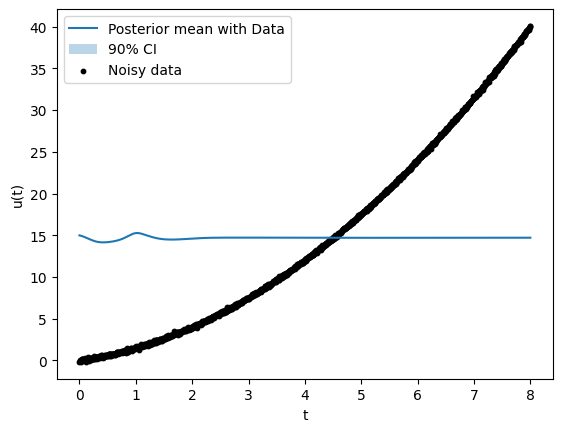

In [ ]:
x = t_test.squeeze().numpy()
plt.plot(x, mean_pred_2, label="Posterior mean with Data")
plt.fill_between(x, lower_90_2, upper_90_2, alpha=0.3, label="90% CI")
plt.scatter(t_obs.numpy(), u_obs.numpy(), c="k", s=10, label="Noisy data")
plt.legend()
plt.xlabel("t"); plt.ylabel("u(t)")
plt.show()